<a href="https://colab.research.google.com/github/shilpamatne/FDP_AdiSankara/blob/main/9N_ConvAutoencoder_AnomalyDetection_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
! unzip '/content/drive/MyDrive/Malaria_dataset.zip' -d '/content/Malaria_datasett/'

In [ ]:

#Size of our input images
SIZE = 128

In [ ]:
#Define generators for training, validation and also anomaly data.

batch_size = 64
datagen = ImageDataGenerator(rescale=1./255)#,rotation_range = 5, shear_range = 0.02,\
                             #zoom_range = 0.02, samplewise_center=True, \
                             #samplewise_std_normalization= True)

train_generator = datagen.flow_from_directory(
    '/content/Malaria_datasett/Malaria dataset/Uninfected_train/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    '/content/Malaria_datasett/Malaria dataset/Uninfected_val/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    '/content/Malaria_datasett/Malaria dataset/Infected/',
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    class_mode='input'
    )


In [ ]:
#Define the autoencoder. 
#Try to make the bottleneck layer size as small as possible to make it easy for
#density calculations and also picking appropriate thresholds. 

#Encoder
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

#Decoder
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()


In [ ]:
#Fit the model. 
history = model.fit(
        train_generator,
        
        epochs=1000,
        validation_data=validation_generator,
        
        shuffle = True)


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Lets get a batch of images. We have used DataGenrator, how it generates a batch of images? using .next()

At the end of this,  we will have all the batches. Each batch will contain 64 items.

In [ ]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

print(len(data_batch))


From the list containing batches, we pick firts batch and do predictions.

In [ ]:
predicted = model.predict(data_batch[0])  #Predict on the first batch of images


Now going to predict on some random images

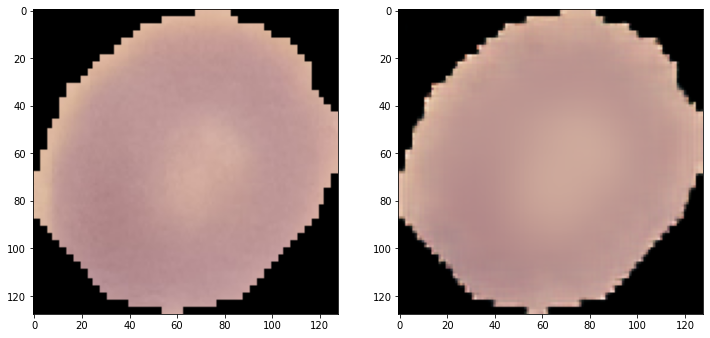

In [ ]:
#view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [ ]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

In [ ]:
def check_anomaly(img_path):
    
    reconstruction_error_threshold = 0.0045 # Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.ANTIALIAS))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    #encoded_img = encoder_model.predict([[img]]) 
    #encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    #density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    if reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")

In [ ]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
para_file_paths = glob.glob('/content/Malaria_datasett/Malaria dataset/Infected/images/*')
uninfected_file_paths = glob.glob('/content/Malaria_datasett/Malaria dataset/Uninfected_train/images/*')


In [ ]:
#Anomaly image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(para_file_paths[num])

In [ ]:
#Good/normal image verification
num=random.randint(0,len(para_file_paths)-1)
check_anomaly(uninfected_file_paths[num])